In [ ]:
!pip install git+https://github.com/forrestbao/pyeeg.git
import numpy as np
import pyeeg as pe
import pickle as pickle
import pandas as pd
import math

from sklearn import svm
from sklearn.preprocessing import normalize

import os
import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-i3g4lu94
  Running command git clone -q https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-i3g4lu94
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28131 sha256=fc8128f87dcca5e4c5ce683b2c3d8c372d6a17d1ed4b4d93cacaa9c3151e0971
  Stored in directory: /tmp/pip-ephem-wheel-cache-3e03yeg7/wheels/b0/23/e4/703c908bda656959957029fa145879aa79307b2545a2ef0271
Successfully built pyeeg


In [ ]:
import pandas as pd
import keras.backend as K
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from keras.layers import Flatten
from keras.layers import Dense
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import Model
import timeit
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D
from tensorflow.keras.optimizers import SGD
#import cv2, numpy as np
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# data_preprocessed_python
import os
import pickle as pickle
os.getcwd()
os.chdir('/content/drive/My Drive')

In [ ]:
channel = [1,2,3,4,6,11,13,17,19,20,21,25,29,31] #14 Channels chosen to fit Emotiv Epoch+
band = [4,8,12,16,25,45] #5 bands
window_size = 256 #Averaging band power of 2 sec
step_size = 16 #Each 0.125 sec update once
sample_rate = 128 #Sampling rate of 128 Hz
subjectList = ['01','02','03']
#List of subjects

In [ ]:
def FFT_Processing (sub, channel, band, window_size, step_size, sample_rate):
  # /content/drive/MyDrive/CSE499ATry2
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    meta = []
    with open("/content/drive/My Drive/CSE499ATry2/s" + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,40):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 0;

            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] #meta vector for analysis
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                    Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                    meta_data = meta_data + list(Y[0])

                meta_array.append(np.array(meta_data))
                meta_array.append(labels)

                meta.append(np.array(meta_array))    
                start = start + step_size
                
        meta = np.array(meta)
        np.save('/content/drive/My Drive/CSE499ATry2/s' + sub, meta, allow_pickle=True, fix_imports=True)

In [ ]:
for subjects in subjectList:
    FFT_Processing (subjects, channel, band, window_size, step_size, sample_rate)

In [ ]:
data_training = []
label_training = []
data_testing = []
label_testing = []

for subjects in subjectList:

    with open('/content/drive/My Drive/CSE499ATry2/s' + subjects + '.npy', 'rb') as file:
      sub = np.load(file,allow_pickle=True)
      for i in range (0,sub.shape[0]):
        if i % 5 == 0:
          data_testing.append(sub[i][0])
          label_testing.append(sub[i][1])
        else:
          data_training.append(sub[i][0])
          label_training.append(sub[i][1])

np.save('/content/drive/My Drive/CSE499ATry2/data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save('/content/drive/My Drive/CSE499ATry2/label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save('/content/drive/My Drive/CSE499ATry2/data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save('/content/drive/My Drive/CSE499ATry2/label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

training dataset: (46848, 70) (46848, 4)
testing dataset: (11712, 70) (11712, 4)


In [ ]:
with open('/content/drive/My Drive/CSE499ATry2/data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)
    
with open('/content/drive/My Drive/CSE499ATry2/label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)
    
X = normalize(X)
Z = np.ravel(Y[:, [3]])

Arousal_Train = np.ravel(Y[:, [0]])
Valence_Train = np.ravel(Y[:, [1]])
Domain_Train = np.ravel(Y[:, [2]])
Like_Train = np.ravel(Y[:, [3]])

In [ ]:
X.shape

(46848, 70)

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(Z)
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
y_train.shape

(46848, 10)

In [ ]:
x_train = np.array(X[:])

In [ ]:
with open('/content/drive/My Drive/CSE499ATry2/data_testing.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain)
    
with open('/content/drive/My Drive/CSE499ATry2/label_testing.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL)

M = normalize(M)
L = np.ravel(N[:, [3]])

Arousal_Test = np.ravel(N[:, [0]])
Valence_Test = np.ravel(N[:, [1]])
Domain_Test = np.ravel(N[:, [2]])
Like_Test = np.ravel(N[:, [3]])

In [ ]:
x_test = np.array(M[:])

In [ ]:
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(L)
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
y_test[1]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [ ]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

In [ ]:
x_train.shape

(46848, 70, 1)

In [ ]:
batch_size = 256
num_classes = 10
epochs = 200
input_shape=(x_train.shape[1], 1)

In [ ]:
print(input_shape)

(70, 1)


In [ ]:
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2

In [ ]:
model = Sequential()
intput_shape=(x_train.shape[1], 1)
model.add(Conv1D(128, kernel_size=3,padding = 'same',activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(64,kernel_size=3,padding = 'same', activation='relu'))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 70, 128)           512       
                                                                 
 batch_normalization (BatchN  (None, 70, 128)          512       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 35, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 35, 128)           49280     
                                                                 
 batch_normalization_1 (Batc  (None, 35, 128)          512       
 hNormalization)                                                 
                                                        

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,  
          verbose=1,validation_data=(x_test,y_test))

Epoch 1/200
183/183 [==============================] - 33s 170ms/step - loss: 1.8043 - accuracy: 0.3037 - val_loss: 1.7610 - val_accuracy: 0.2824
Epoch 2/200
183/183 [==============================] - 31s 168ms/step - loss: 1.4967 - accuracy: 0.4050 - val_loss: 1.4632 - val_accuracy: 0.3946
Epoch 3/200
183/183 [==============================] - 32s 173ms/step - loss: 1.3644 - accuracy: 0.4577 - val_loss: 1.1905 - val_accuracy: 0.5242
Epoch 4/200
183/183 [==============================] - 31s 168ms/step - loss: 1.2576 - accuracy: 0.4997 - val_loss: 1.0707 - val_accuracy: 0.5722
Epoch 5/200
183/183 [==============================] - 31s 167ms/step - loss: 1.1754 - accuracy: 0.5348 - val_loss: 1.0140 - val_accuracy: 0.5915
Epoch 6/200
183/183 [==============================] - 31s 167ms/step - loss: 1.1026 - accuracy: 0.5595 - val_loss: 0.9750 - val_accuracy: 0.6054
Epoch 7/200
183/183 [==============================] - 31s 167ms/step - loss: 1.0518 - accuracy: 0.5805 - val_loss: 0.9179 -

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

366/366 [==============================] - 4s 9ms/step - loss: 0.4426 - accuracy: 0.8819
Test loss: 0.44262149930000305
Test accuracy: 0.8819159865379333


In [ ]:
# list all data in history
print(history.history.keys())
import matplotlib.pyplot as plt
import numpy

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


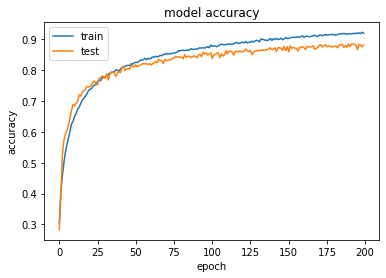

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

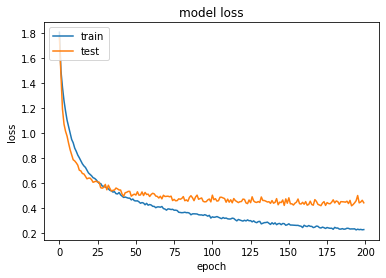

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

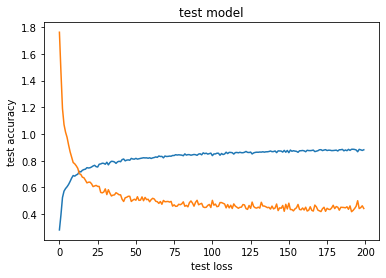

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.title('test model')
plt.ylabel('test accuracy')
plt.xlabel('test loss')
plt.show()


In [ ]:
# Load the library
from tensorflow.keras.models import load_model
# Save the model using TensorFlow SavedModel format
model.save('/content/drive/My Drive/CSE499ATry2')